# SI 330: Final Data Analysis Project 

## Topic: Analyzing English Premier League Data

### By: Yasemin Gunal (gunaly)

### Imports:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sqlite3 import connect

### Website Scrape & Calculations

In [2]:
salaries2 = pd.read_html('https://salarysport.com/football/premier-league/highest-paid/')[0]

salaries2['Yearly Wage'] = salaries2['Yearly Wage'].astype('string').str[1:]
salaries2['Yearly Wage'] = salaries2['Yearly Wage'].str.replace(',','')
salaries2['Name'] = salaries2['Name'].astype('string')


salaries2 = salaries2[['Name', 'Yearly Wage']]
salaries2.columns = ['name', 'yearly_wage']

salaries2 = salaries2.drop([11, 22]) #drop values with NaN


salaries2['yearly_wage'] = salaries2['yearly_wage'].astype(int)
salaries2['salary_in_millions'] = round((salaries2['yearly_wage']/1000000), 3)


salaries2.dtypes
salaries2.head()

,name,yearly_wage,salary_in_millions
0,Gareth Bale,29328000,29.328
1,David De Gea,18200000,18.200
2,Paul Pogba,15080000,15.080
3,N'Golo Kanté,15080000,15.080
4,Timo Werner,13936000,13.936


### Reading in and cleaning CSV files

In [3]:
epl_csv = pd.read_csv('EPL_20_21.csv')
epl_csv = epl_csv.drop(['Penalty_Attempted', 'xG', 'xA', ], axis=1)
epl_csv.columns=['name', 'club', 'nationality', 'position', 'age', 'matches', 'starts', 'mins', 'goals', 'assists', 'passes_attempted', 'perc_passes_complete', 'penalty_goals', 'yellow_cards', 'red_cards']
epl_csv.head()


,name,club,nationality,position,age,matches,starts,mins,goals,assists,passes_attempted,perc_passes_complete,penalty_goals,yellow_cards,red_cards
0,Mason Mount,Chelsea,ENG,"MF,FW",21,36,32,2890,6,5,1881,82.3,1,2,0
1,Edouard Mendy,Chelsea,SEN,GK,28,31,31,2745,0,0,1007,84.6,0,2,0
2,Timo Werner,Chelsea,GER,FW,24,35,29,2602,6,8,826,77.2,0,2,0
3,Ben Chilwell,Chelsea,ENG,DF,23,27,27,2286,3,5,1806,78.6,0,3,0
4,Reece James,Chelsea,ENG,DF,20,32,25,2373,1,2,1987,85.0,0,3,0


Filtering CSV for defenders and creating a DataFrame of only the defenders:

In [4]:
defenders_only = epl_csv[(epl_csv['position'] == 'DF')]
defenders_only.head()

cards_per_team_defenders_only = defenders_only[['club', 'yellow_cards']].groupby('club').sum()
cards_per_team_defenders_only.columns = ['yellow_cards_of_defenders']

cards_per_team_defenders_only.sort_values('yellow_cards_of_defenders', ascending=False).head()


,yellow_cards_of_defenders
club,
Leicester City,33
Aston Villa,29
Sheffield United,28
Manchester United,28
Newcastle United,26


In [5]:
forwards_only = epl_csv[(epl_csv['position']) == 'FW']
cards_per_team_forwards_only = forwards_only[['club', 'yellow_cards']].groupby('club').sum()
cards_per_team_forwards_only.head()


,yellow_cards
club,
Arsenal,6
Aston Villa,7
Brighton,0
Burnley,5
Chelsea,3


In [6]:
mids_only = epl_csv[(epl_csv['position']) == 'MF']
assists_per_team_mids_only = mids_only[['club', 'assists', 'goals']].groupby('club').sum()
assists_per_team_mids_only.head()


,assists,goals
club,,
Arsenal,7,2
Aston Villa,9,7
Brighton,0,1
Burnley,10,8
Chelsea,4,7


Creating a 'Successful Passes' column based on the percentage of successful player passes and how many passes they attempted

In [7]:
for idx, row in epl_csv.iterrows():
    epl_csv['successful_passes'] = epl_csv.apply(lambda row: round(row['passes_attempted'] * (row['perc_passes_complete']/100)), axis=1)

num_passes_per_team = epl_csv[['club', 'successful_passes']].groupby('club').sum().sort_values('successful_passes', ascending=False)
num_passes_per_team.head()

,successful_passes
club,
Manchester City,23582
Chelsea,21648
Liverpool FC,21527
Manchester United,18496
Arsenal,17802


Calculating the number of players per team and the total age per team in order to then calculate the average age of each team (and creating a column for that value)

In [8]:
num_players_per_team = epl_csv.value_counts('club')
num_players_per_team = (num_players_per_team.to_frame('num_players'))
age_per_team = epl_csv[['club', 'age']].groupby('club').sum()
#display(num_players_per_team.head(), age_per_team.head())

merged_df = age_per_team.merge(num_players_per_team, on='club')

avg_ages = []
for idx, row in merged_df.iterrows():
    merged_df['avg_age'] = merged_df.apply(lambda row: round((row['age'] / row['num_players']), 3), axis=1)

merged_df = merged_df.sort_values('avg_age', ascending=True)
merged_df.head()

,age,num_players,avg_age
club,,,
Manchester United,692,29,23.862
Southampton,700,29,24.138
Aston Villa,583,24,24.292
Wolverhampton Wanderers,660,27,24.444
Brighton,663,27,24.556


Calculating the number of total yellow cards each team recieved throughout the season (based on how many each individual player recieved)

In [9]:
cards_per_team = epl_csv[['club', 'yellow_cards']].groupby('club').sum()
cards_per_team = cards_per_team.sort_values('yellow_cards', ascending=True)

Merging DataFrames with age and yellow card count information so all data is stored in one DataFrame

In [10]:
merged_df2 = merged_df.merge(cards_per_team, on='club')
team_summed_info = merged_df2.merge(num_passes_per_team, on='club')
team_summed_info.head()

,age,num_players,avg_age,yellow_cards,successful_passes
club,,,,,
Manchester United,692,29,23.862,64,18496
Southampton,700,29,24.138,52,14755
Aston Villa,583,24,24.292,71,12782
Wolverhampton Wanderers,660,27,24.444,55,15232
Brighton,663,27,24.556,49,15600


_____________________________________________________________________

Creating a player_influence DataFrame that includes how many total yellow and red cards a player recieved and then filtering that DataFrame for only players who are Forwards (or both Midfielders and Forwards)

In [12]:
player_influence = epl_csv[['name', 'position', 'matches', 'mins', 'goals', 'yellow_cards', 'red_cards']]

for idx, row in player_influence.iterrows():
    player_influence['card_points'] = epl_csv.apply(lambda row: row['yellow_cards'] + row['red_cards'], axis=1)

player_influence = player_influence.drop(['yellow_cards', 'red_cards'], axis=1)

<ipython-input-12-1879ceb00e20>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_influence['card_points'] = epl_csv.apply(lambda row: row['yellow_cards'] + row['red_cards'], axis=1)


In [13]:
forwards_influence = player_influence[(player_influence['position'] == 'FW') | (player_influence['position'] == 'MF/FW')]
forwards_influence.head()


,name,position,matches,mins,goals,card_points
2,Timo Werner,FW,35,2602,6,2
16,Tammy Abraham,FW,22,1040,6,0
19,Olivier Giroud,FW,17,748,4,1
23,Ruben Loftus-Cheek,FW,1,60,0,0
30,Raheem Sterling,FW,31,2536,10,4


Using the salaries DataFrame created from the website scrape, I merged the information pertaining to the forwards/midfielders to obtain each players performance and their salary in one DataFrame

In [14]:
forwards_influence_salaries = salaries2.merge(forwards_influence, on='name')
forwards_influence_salaries = forwards_influence_salaries.drop_duplicates(subset='name')
forwards_influence_salaries.head().sort_values('salary_in_millions', ascending=False)

forwards_influence_salaries['name'] = forwards_influence_salaries['name'].astype('string')

forwards_influence_salaries.dtypes
forwards_influence_salaries.head()

,name,yearly_wage,salary_in_millions,position,matches,mins,goals,card_points
0,Gareth Bale,29328000,29.328,FW,20,920,11,1
1,Timo Werner,13936000,13.936,FW,35,2602,6,2
2,Pierre-Emerick Aubameyang,13000000,13.000,FW,29,2332,10,2
3,Mohamed Salah,10400000,10.400,FW,37,3078,22,0
4,Harry Kane,10400000,10.400,FW,35,3082,23,1


Creating scatterplots to help visualize the relationship between a forward's salary and the number of goals they have scored, and their salary versus the number of matches they have played in

<AxesSubplot:title={'center':'Salary v. Num Goals Scored'}, xlabel='salary_in_millions', ylabel='goals'>

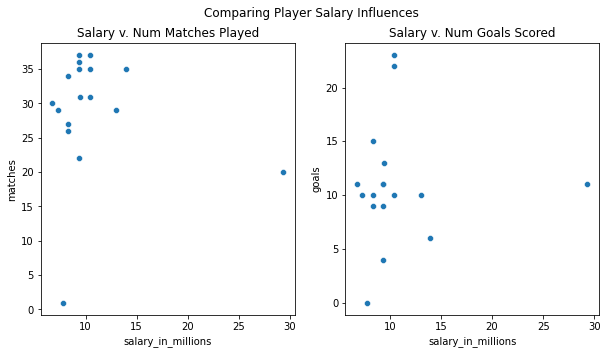

In [15]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
axes[0].set_title('Salary v. Num Matches Played')
axes[1].set_title('Salary v. Num Goals Scored')
fig.suptitle('Comparing Player Salary Influences')

sns.scatterplot(ax=axes[0], x='salary_in_millions', y='matches', data=forwards_influence_salaries)

sns.scatterplot(ax=axes[1], x='salary_in_millions', y='goals', data=forwards_influence_salaries)


_____________________________________________________________________

### Reading in DataBase & DataBase Calculations

In [16]:
conn = connect('epl_database')

epl_db_df = pd.read_sql(
    "SELECT Referee, HomeTeam, AwayTeam, FTHG, FTAG, FTR, HTR FROM football_data WHERE League='Premier League' and Country='England' and Season='2020/2021'", conn)

epl_db_df.head()


,Referee,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTR
0,K Friend,Sheffield United,Burnley,1,0,H,H
1,M Atkinson,West Ham,Southampton,3,0,H,H
2,M Dean,Wolves,Man United,1,2,A,A
3,J Moss,Arsenal,Brighton,2,0,H,D
4,M Oliver,Man City,Everton,5,0,H,H


Calculating the goals conceded by each club in the 2020/21 season based on the Away Team and Home Team goals scored against

In [17]:
goals_conceded_dict = {}

for idx, row in epl_db_df.iterrows():
    if row['HomeTeam'] not in goals_conceded_dict.keys():
        goals_conceded_dict[row['HomeTeam']] = row['FTAG']
    else: 
        goals_conceded_dict[row['HomeTeam']] += row['FTAG']
    
    if row['AwayTeam'] not in goals_conceded_dict.keys():
        goals_conceded_dict[row['AwayTeam']] = row['FTHG']
    else: 
        goals_conceded_dict[row['AwayTeam']] += row['FTHG']

display(goals_conceded_dict) #cross checked with premier league website


{'Sheffield United': 63,
 'Burnley': 55,
 'West Ham': 47,
 'Southampton': 68,
 'Wolves': 52,
 'Man United': 44,
 'Arsenal': 39,
 'Brighton': 46,
 'Man City': 32,
 'Everton': 48,
 'Aston Villa': 46,
 'Chelsea': 36,
 'Liverpool': 42,
 'Crystal Palace': 66,
 'Leicester': 50,
 'Tottenham': 45,
 'Leeds': 54,
 'West Brom': 76,
 'Fulham': 53,
 'Newcastle': 62}

In [18]:
club_names = goals_conceded_dict.keys()
goals_conc = goals_conceded_dict.values()

goals_conceded = pd.DataFrame({'club': club_names, 'num_goals_conceded':goals_conc}).set_index('club')
goals_conceded = goals_conceded.rename(index={'Man City': 'Manchester City', 'Man United': 'Manchester United', 'Leicester': 'Leicester City', 'Liverpool': 'Liverpool FC', 'West Ham': 'West Ham United', 'Tottenham': 'Tottenham Hotspur', 'Newcastle': 'Newcastle United', 'Wolves': 'Wolverhampton Wanderers', 'West Brom': 'West Bromwich Albion'})

goals_conceded.head()



,num_goals_conceded
club,
Sheffield United,63
Burnley,55
West Ham United,47
Southampton,68
Wolverhampton Wanderers,52


Calculating the probability that a team will win or lose based on their Home or Away status and the score at half-time

In [19]:
ties_at_half = epl_db_df[epl_db_df['HTR'] == 'D']
ties_at_half['FTR'].value_counts()

A    59
D    53
H    41
Name: FTR, dtype: int64

In [20]:
away_when_tie = 59/153
tie_when_tie = 53/153
home_when_tie = 41/153

display(away_when_tie, tie_when_tie, home_when_tie)

0.38562091503267976

0.3464052287581699

0.2679738562091503

In [21]:
away_win_at_half = epl_db_df[epl_db_df['HTR'] == 'A']
away_win_at_half['FTR'].value_counts()

A    85
D    13
H     9
Name: FTR, dtype: int64

In [22]:
away_when_away = 85/107
tie_when_away = 13/107
home_when_away = 9/107

display(away_when_away, tie_when_away, home_when_away)

0.794392523364486

0.12149532710280374

0.08411214953271028

In [23]:
home_win_at_half = epl_db_df[epl_db_df['HTR'] == 'H']
home_win_at_half['FTR'].value_counts()

H    94
D    17
A     9
Name: FTR, dtype: int64

In [24]:
home_when_home =  94/120
tie_when_home = 17/120
away_when_home = 9/120

display(home_when_home, tie_when_home, away_when_home)

0.7833333333333333

0.14166666666666666

0.075

_____________________________________________________________________

Iterating through the database to obtain the number of wins for each team. This information was collected into a dictionary that was then re-formatted into a Dataframe

In [25]:
team_wins_dict = {}

for idx, row in epl_db_df.iterrows():
    if row['FTR'] == 'H':
        if row['HomeTeam'] not in team_wins_dict.keys():
            team_wins_dict[row['HomeTeam']] = 1
        else: 
            team_wins_dict[row['HomeTeam']] += 1
    elif row['FTR'] == 'A':
        if row['AwayTeam'] not in team_wins_dict.keys():
            team_wins_dict[row['AwayTeam']] = 1
        else: 
            team_wins_dict[row['AwayTeam']] += 1

# print(team_wins_dict)

teams = team_wins_dict.keys()
num_wins = team_wins_dict.values()

wins_per_team = pd.DataFrame({'club':teams, 'num_wins':num_wins}).sort_values(by=['num_wins'], ascending=False).set_index('club')
wins_per_team_new = wins_per_team.rename(index={'Man City': 'Manchester City', 'Man United': 'Manchester United', 'Leicester': 'Leicester City', 'Liverpool': 'Liverpool FC', 'West Ham': 'West Ham United', 'Tottenham': 'Tottenham Hotspur', 'Newcastle': 'Newcastle United', 'Wolves': 'Wolverhampton Wanderers', 'West Brom': 'West Bromwich Albion'})
wins_per_team_new.head()

,num_wins
club,
Manchester City,27
Manchester United,21
Leicester City,20
Liverpool FC,20
West Ham United,19


Next, all information was organized into a single DataFrame by merging the database information on the number of team wins and the information on the average age, yellow cards recieved, and successful passes of each team:

In [26]:
merged_db_csv = team_summed_info.merge(wins_per_team_new, on='club').drop(['age', 'num_players'], axis=1)
merged_db_csv.head()


,avg_age,yellow_cards,successful_passes,num_wins
club,,,,
Manchester United,23.862,64,18496,21
Southampton,24.138,52,14755,12
Aston Villa,24.292,71,12782,16
Wolverhampton Wanderers,24.444,55,15232,12
Brighton,24.556,49,15600,9


Creating scatterplot in order to visualize the relationship between the number of club wins versus club average age, club yellow cards, and club successful passes throughout the 2020-21 season.

[Text(0.5, 1.0, 'Successful Team Passes vs. Number of Wins')]

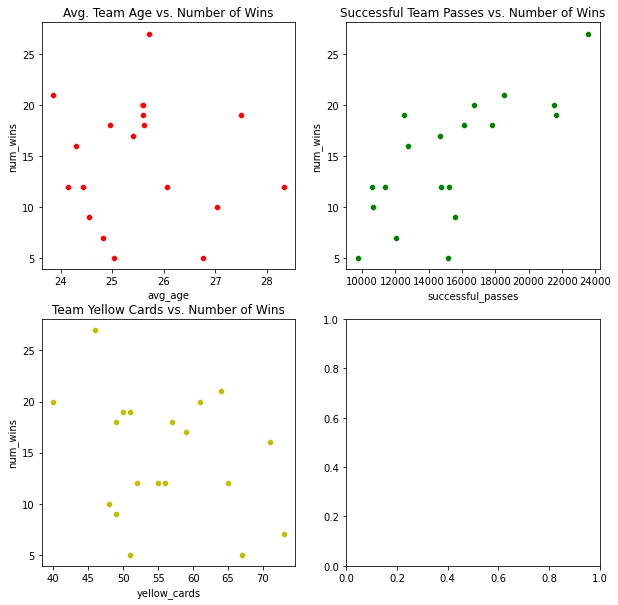

In [27]:
f, axes=plt.subplots(2,2, figsize=(10, 10))
sns.scatterplot(data=merged_db_csv, y='num_wins', x='avg_age', ax=axes[0,0], color='r').set(title='Avg. Team Age vs. Number of Wins')
sns.scatterplot(data=merged_db_csv, y='num_wins', x='yellow_cards', ax=axes[1,0], color='y').set(title='Team Yellow Cards vs. Number of Wins')
sns.scatterplot(data=merged_db_csv, y='num_wins', x='successful_passes', ax=axes[0,1], color='g').set(title='Successful Team Passes vs. Number of Wins')

Creating scatterplots in order to visualize the relationship between the aggression of different team positions and how the team performs. First: defensive line aggression vs. number of goals conceded
Second: offensive line aggression vs. number of wins

In [28]:
defense_aggression = goals_conceded.merge(cards_per_team_defenders_only, on='club')
defense_aggression.head()


,num_goals_conceded,yellow_cards_of_defenders
club,,
Sheffield United,63,28
Burnley,55,20
West Ham United,47,21
Southampton,68,21
Wolverhampton Wanderers,52,22


[Text(0.5, 1.0, 'Defender Aggression vs. Number of Goals Conceded')]

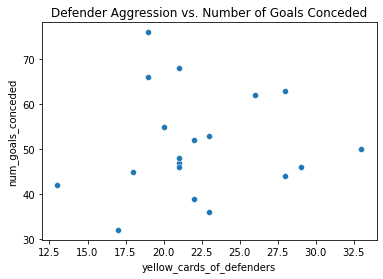

In [29]:
sns.scatterplot(data=defense_aggression, y='num_goals_conceded', x='yellow_cards_of_defenders').set(title='Defender Aggression vs. Number of Goals Conceded')


In [30]:
forward_aggression = cards_per_team_forwards_only.merge(wins_per_team_new, on='club')
forward_aggression.head()


,yellow_cards,num_wins
club,,
Arsenal,6,18
Aston Villa,7,16
Brighton,0,9
Burnley,5,10
Chelsea,3,19


[Text(0.5, 1.0, 'Forward Aggression vs. Number of Wins')]

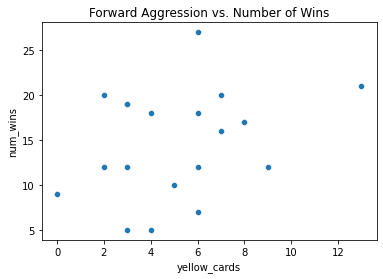

In [31]:
sns.scatterplot(data=forward_aggression, y='num_wins', x='yellow_cards').set(title='Forward Aggression vs. Number of Wins')


In [32]:
mf_assist_influence = assists_per_team_mids_only.merge(wins_per_team_new, on='club')
mf_assist_influence.head()


,assists,goals,num_wins
club,,,
Arsenal,7,2,18
Aston Villa,9,7,16
Brighton,0,1,9
Burnley,10,8,10
Chelsea,4,7,19


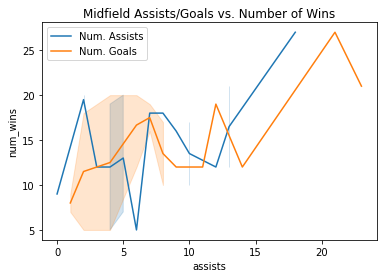

In [33]:
sns.lineplot(data=mf_assist_influence, y='num_wins', x='assists').set(title='Midfield Assists/Goals vs. Number of Wins')
sns.lineplot(data=mf_assist_influence, y='num_wins', x='goals')

plt.legend(labels=["Num. Assists","Num. Goals"])
